
# Adding Limit Orders to the Trading Bot (Take Profit & Stop Loss) 

In [1]:
import sys
sys.path.append("../")
from trading.api import OANDA_API
import pandas as pd
import numpy as np
import tpqoa
from datetime import datetime, timedelta, timezone
import time
import pytz
from datetime import datetime

import matplotlib.pyplot as plt
from trading import MyTT

In [2]:
instrument = "EUR_HKD"
bar_length = timedelta(minutes = 1)
SMA = 200
dev = 2

In [3]:
# raw_data = None
# now = datetime.utcnow()
       
# now = now - timedelta(microseconds = now.microsecond)
# past = now - timedelta(days = 2)


# print (f"Getting candles for {instrument}, from {past} to {now}")

# raw_df = tpqoa.tpqoa("../../config/oanda_demo.cfg").get_history(instrument = instrument, start = past, end = now,
#                        granularity = "S30", price = "M", localize = True).c.dropna().to_frame()

# raw_df.rename(columns = {"c":instrument}, inplace = True)


# # last_bar = raw_data.index[-1].to_pydatetime().replace(tzinfo=None)
        

In [4]:
# raw_df = pd.read_pickle(f"../../data/backtest_{instrument}.pcl")

In [5]:
api = OANDA_API("../../config/oanda.cfg")
raw_df = api.get_history_with_all_prices(instrument, 20)

In [6]:
raw_df

,ask,bid,EUR_HKD
time,,,
2024-02-01 15:09:00,8.46590,8.46440,8.465150
2024-02-01 15:09:30,8.46589,8.46426,8.465075
2024-02-01 15:10:00,8.46461,8.46286,8.463735
2024-02-01 15:10:30,8.46587,8.46440,8.465135
2024-02-01 15:11:00,8.46558,8.46390,8.464740
...,...,...,...
2024-02-21 15:07:00,8.45977,8.45830,8.459035
2024-02-21 15:07:30,8.46003,8.45870,8.459365
2024-02-21 15:08:00,8.45991,8.45855,8.459230


In [7]:
df = raw_df.copy()
    
df["SMA"] = df[instrument].rolling(SMA).mean()
std = df[instrument].rolling(SMA).std() * dev
df["std"] = df[instrument].rolling(60).std()
df["std_sma"] = df["std"].rolling(60).mean()
df []
df["Lower"] = df["SMA"] - std
df["Upper"] = df["SMA"] + std

df


,ask,bid,EUR_HKD,SMA,std,std_sma,Lower,Upper,long_momentum
time,,,,,,,,,
2024-02-01 15:09:00,8.46590,8.46440,8.465150,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-01 15:09:30,8.46589,8.46426,8.465075,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-01 15:10:00,8.46461,8.46286,8.463735,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-01 15:10:30,8.46587,8.46440,8.465135,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-01 15:11:00,8.46558,8.46390,8.464740,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2024-02-21 15:07:00,8.45977,8.45830,8.459035,8.455562,0.001786,0.001660,8.451358,8.459767,-0.000673
2024-02-21 15:07:30,8.46003,8.45870,8.459365,8.455603,0.001744,0.001658,8.451412,8.459795,-0.000642
2024-02-21 15:08:00,8.45991,8.45855,8.459230,8.455644,0.001713,0.001656,8.451469,8.459818,-0.000662


In [8]:
df.tail(20)

,ask,bid,EUR_HKD,SMA,std,std_sma,Lower,Upper,long_momentum
time,,,,,,,,,
2024-02-21 14:59:30,8.45830,8.45702,8.457660,8.455126,0.002010,0.001540,8.450971,8.459281,-0.000362
2024-02-21 15:00:00,8.45871,8.45730,8.458005,8.455147,0.002021,0.001553,8.450976,8.459318,-0.000360
2024-02-21 15:00:30,8.45820,8.45686,8.457530,8.455161,0.002027,0.001565,8.450977,8.459345,-0.000315
2024-02-21 15:01:00,8.45702,8.45567,8.456345,8.455174,0.002023,0.001577,8.450992,8.459356,-0.000140
2024-02-21 15:01:30,8.45660,8.45517,8.455885,8.455186,0.002020,0.001589,8.451011,8.459362,-0.000226
2024-02-21 15:02:00,8.45840,8.45698,8.457690,8.455208,0.002013,0.001600,8.451024,8.459391,-0.000377
2024-02-21 15:02:30,8.45880,8.45736,8.458080,8.455234,0.002019,0.001611,8.451045,8.459423,-0.000474
2024-02-21 15:03:00,8.45960,8.45835,8.458975,8.455264,0.002033,0.001622,8.451054,8.459473,-0.000712
2024-02-21 15:03:30,8.45890,8.45747,8.458185,8.455292,0.002003,0.001631,8.451079,8.459504,-0.000547


In [15]:
filtered_df = df.query("time >= '2024-02-20 09:00:00' and time < '2024-02-20 14:00:00'")

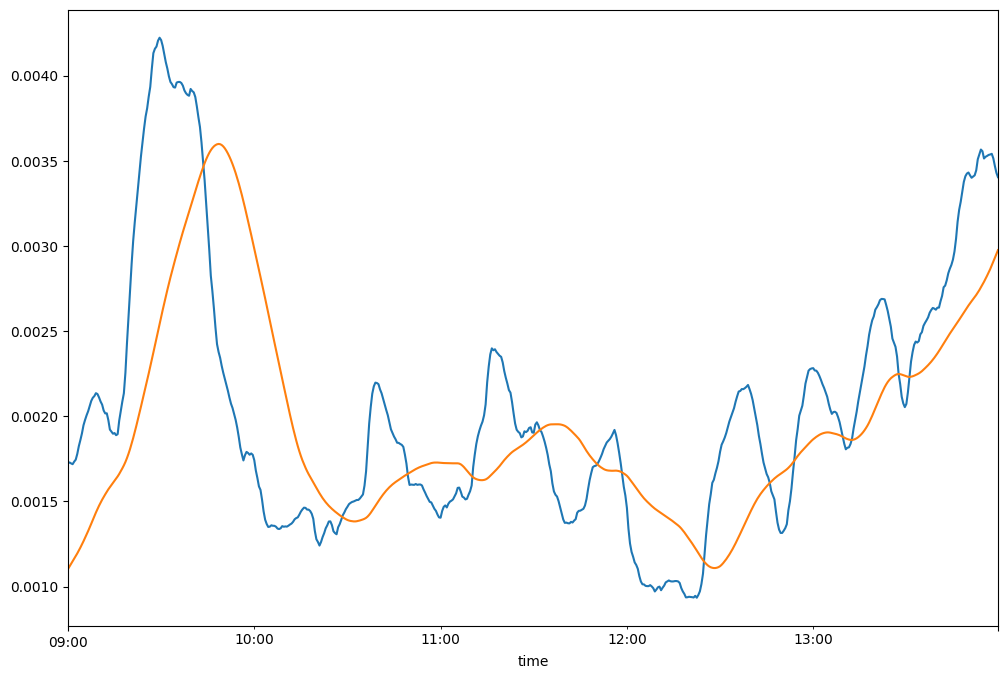

In [16]:
# filtered_df[instrument].plot(figsize = (12, 8))
filtered_df["std"].plot(figsize = (12, 8))
filtered_df["std_sma"].plot(figsize = (12, 8))
# filtered_df["std_upper"].plot(figsize = (12, 8), secondary_y = "position")
# filtered_df["std_lower"].plot(figsize = (12, 8), secondary_y = "position")

plt.show()

In [17]:
# M = filtered_df["SMA"].values
# M = pd.Series(M)
# poly = np.polyfit(M.index, M.values, deg=1)
# poly
slope = MyTT.SLOPE(filtered_df["SMA"].values)
slope = round(slope, 6)
slope


3.9e-05

In [18]:
'{0:f}'.format(slope)

'0.000039'

In [19]:
long_momentum = df["long_momentum"][-1]
long_momentum = long_momentum
'{0:f}'.format(long_momentum)

'-0.000758'

<Axes: xlabel='time'>

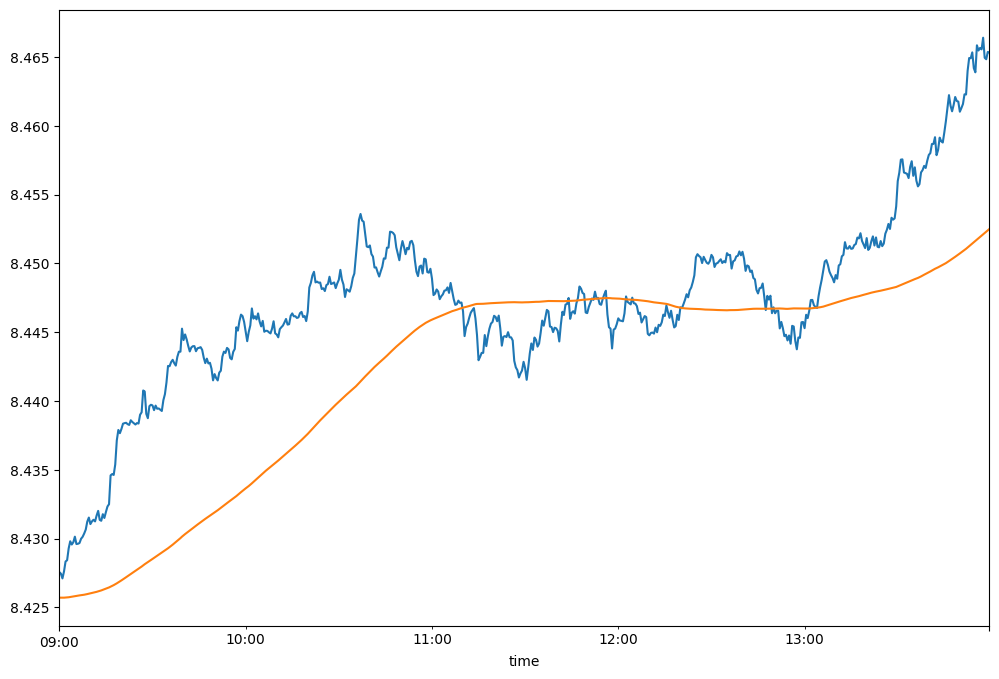

In [20]:
filtered_df[instrument].plot(figsize = (12, 8))
filtered_df["SMA"].plot(figsize = (12, 8))